In [1]:
# https://huggingface.co/docs/timm/quickstart
# https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055

In [24]:
import torch
import numpy as np 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [25]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Subset

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline


# utils
import numpy as np
from torchsummary import summary
import time
import copy

import os
from tqdm.notebook import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.backends import cudnn
cudnn.benchmark = True
from randaugment import RandAugment, ImageNetPolicy
from torch.autograd import Variable


import timm
from timm.data.transforms_factory import create_transform
from timm.data.dataset_factory import create_dataset
from timm.data.mixup import Mixup

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 예시로 'NanumGothic'을 사용

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [26]:
# timm.list_models()

In [27]:
# timm.list_modules()

In [28]:
tfm = create_transform(224, is_training=True, auto_augment='rand-m6-mstd0.5', mean =[0.49623227595753333,0.48377202969644434,0.39612923273387035], std=[0.21602388510121484,0.2127661699292398,0.2127661699292398] )

train_ds = create_dataset(name= '', root='../../data/image_dataset/train_image_dataset', transform = tfm)
val_ds = create_dataset(name= '', root='../../data/image_dataset/test_image_dataset', transform = create_transform(224))

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=6)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=6)

In [29]:
type(train_dl)

torch.utils.data.dataloader.DataLoader

In [30]:
# Mixup 인자 설정
mixup_args = {
    'mixup_alpha': 1.,
    'cutmix_alpha': 1.,
    'prob': 1,
    'switch_prob': 0.5,
    'mode': 'batch',
    'label_smoothing': 0.1,
    'num_classes': 13
}

# Mixup 객체 생성
mixup_fn = Mixup(**mixup_args)

class MixupDataLoader(DataLoader):
    def __init__(self, *args, mixup_fn, **kwargs):
        super().__init__(*args, **kwargs)
        self.mixup_fn = mixup_fn

    def __iter__(self):
        for batch in super().__iter__():
            inputs, targets = batch
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            mixed_inputs, mixed_targets = self.mixup_fn(inputs, targets)
            yield mixed_inputs, mixed_targets
            
            

In [31]:
train_dl = MixupDataLoader(train_ds, mixup_fn=mixup_fn, batch_size=32, shuffle=True, num_workers=6)

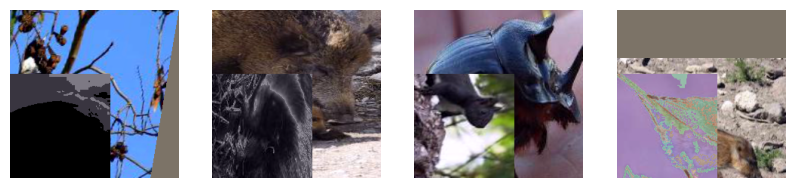

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# DataLoader에서 데이터를 가져옵니다.
dataiter = iter(train_dl)
images, labels = next(dataiter)

# 이미지를 CPU로 옮긴 후 NumPy 배열로 변환합니다.
images = images.cpu().numpy()

# 이미지 표시 함수를 정의합니다.
def imshow(img):
    # [C, H, W]를 [H, W, C]로 변경합니다.
    img = img.transpose((1, 2, 0))
    # 표준화된 데이터를 원본 범위로 되돌립니다.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    # 이미지의 범위가 [0, 1]이 되도록 클리핑합니다.
    img = np.clip(img, 0, 1)
    # 이미지를 표시합니다.
    plt.imshow(img)

# 이미지를 표시합니다.
plt.figure(figsize=(10, 4))
for i in range(4):
    ax = plt.subplot(1, 4, i+1)
    imshow(images[i])
    # ax.set_title(f'Label: {labels[i]}') # 여기서 labels[i].item()을 사용하여 레이블을 스칼라로 변환합니다.
    plt.axis('off') # 축을 표시하지 않습니다.
plt.show()

In [53]:
labels[0]

tensor([0.0077, 0.0077, 0.0077, 0.3369, 0.5785, 0.0077, 0.0077, 0.0077, 0.0077,
        0.0077, 0.0077, 0.0077, 0.0077], device='cuda:0')

In [34]:
# def display_images():
#     fig, subplots = plt.subplots(1,5, figsize=(13,6))
#     for i in range(5):
#         axil = subplots.flat[i]
#         original_img = Image.fromarray(cifar10.data[i])
#         axil.imshow(original_img)
#         axil.set_title('original_img')

In [35]:
# # display sample images 
# def show(img, y=None, color=True):
#     npimg = img.numpy()
#     npimg_tr = np.transpose(npimg, (1,2,0))
#     plt.imshow(npimg_tr)
# 
#     if y is not None:
#         plt.title('labels :' + str(y))
# 
# np.random.seed(1)
# torch.manual_seed(1)
# 
# grid_size = 4
# rnd_inds = np.random.randint(0, len(train_ds), grid_size)
# print('image indices:',rnd_inds)
# 
# x_grid = [train_ds[i][0] for i in rnd_inds]
# y_grid = [train_ds[i][1] for i in rnd_inds]
# 
# x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
# 
# show(x_grid, y_grid)

In [36]:
model = timm.create_model('resnet101', pretrained=True, num_classes=13)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [37]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)
lr_scheduler = StepLR(opt, step_size=1, gamma=0.8)

In [38]:
# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def metric_batch(output, target):
    # target이 원-핫 인코딩된 형태라면, 클래스의 개수에 맞게 변환
    if target.size(1) != output.size(1):
        target = F.one_hot(target, num_classes=output.size(1)).to(output.dtype)

    mse = F.mse_loss(output, target, reduction='none').mean(1)  # 각 샘플에 대한 MSE 계산
    return mse.mean().item()  # 배치에 대한 평균 MSE 반환

# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:

        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [39]:
# class LabelSmoothingLoss(nn.Module):
#     def __init__(self, classes, smoothing=0.1, dim=-1):
#         super(LabelSmoothingLoss, self).__init__()
#         self.confidence = 1.0 - smoothing
#         self.smoothing = smoothing
#         self.cls = classes
#         self.dim = dim
# 
#     def forward(self, pred, target):
#         pred = pred.log_softmax(dim=self.dim)
#         with torch.no_grad():
#             true_dist = torch.zeros_like(pred)
#             true_dist.fill_(self.smoothing / (self.cls - 1))
#             true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
# 
#         return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [40]:
# # function to start training
# def train_val(model, params):
#     num_epochs=params['num_epochs']
#     loss_func=params["loss_func"]
#     opt=params["optimizer"]
#     train_dl=params["train_dl"]
#     val_dl=params["val_dl"]
#     sanity_check=params["sanity_check"]
#     lr_scheduler=params["lr_scheduler"]
#     path2weights=params["path2weights"]
# 
#     loss_history = {'train': [], 'val': []}
#     metric_history = {'train': [], 'val': []}
# 
#     # # GPU out of memoty error
#     # best_model_wts = copy.deepcopy(model.state_dict())
# 
#     best_loss = float('inf')
# 
#     start_time = time.time()
# 
#     for epoch in range(num_epochs):
#         current_lr = get_lr(opt)
#         print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
# 
#         model.train()
#         train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
#         loss_history['train'].append(train_loss)
#         metric_history['train'].append(train_metric)
# 
#         model.eval()
#         with torch.no_grad():
#             val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
#         loss_history['val'].append(val_loss)
#         metric_history['val'].append(val_metric)
# 
#         if val_loss < best_loss:
#             best_loss = val_loss
#             # best_model_wts = copy.deepcopy(model.state_dict())
# 
#             torch.save(model.state_dict(), path2weights)
#             print('Copied best model weights!')
#             print('Get best val_loss')
# 
#         # lr_scheduler.step(val_loss)
#         lr_scheduler.step()
#         print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
#         print('-'*10)
# 
#     # model.load_state_dict(best_model_wts)
# 
#     return model, loss_history, metric_history

In [41]:
# # definc the training parameters
# params_train = {
#     'num_epochs':10,
#     'optimizer':opt,
#     'loss_func':loss_func,
#     'train_dl':train_dl,
#     'val_dl':val_dl,
#     'sanity_check':False,
#     'lr_scheduler':lr_scheduler,
#     'path2weights':'../../weight/test.pth',
# }
# 
# # create the directory that stores weights.pt
# def createFolder(directory):
#     try:
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#     except OSerror:
#         print('Error')
# createFolder('./models')

In [42]:
# model, loss_hist, metric_hist = train_val(model, params_train)

In [45]:
def train(model, loss_func, optimizer, train_loader, epochs, device):
    model.to(device)
    start_time = time.time()
    
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch+1,epochs, current_lr))
        
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_func(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        lr_scheduler.step()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Loss: {avg_loss:.4f}, Time: {((time.time()-start_time)/60):.6f}')
        print('-------------------------------')

In [46]:
train(model, loss_func, opt, train_dl, 10, device = device)

Epoch 1/10, current lr=0.0008
Loss: 47.4720, Time: 2.093520
-------------------------------
Epoch 2/10, current lr=0.00064


KeyboardInterrupt: 

In [21]:
# 테스트 데이터셋에 대한 모델의 정확도를 계산하는 함수
def evaluate_model(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    running_corrects = 0

    # 기울기 계산을 비활성화

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    # 전체 정확도 계산
    accuracy = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

# 테스트 데이터셋을 사용하여 모델 평가
evaluate_model(model, val_dl)

Test Accuracy: 0.9823


In [22]:
# 테스트 데이터셋에 대한 모델의 클래스별 정확도를 계산하는 함수
def evaluate_model_per_class(model, test_loader, num_classes):
    model.eval()  # 모델을 평가 모드로 설정
    class_correct = [0 for _ in range(num_classes)]
    class_total = [0 for _ in range(num_classes)]

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(labels, preds):
                if label == prediction:
                    class_correct[label] += 1
                class_total[label] += 1

    for i in range(num_classes):
        if class_total[i] == 0:
            print(f'Accuracy of class {i} : N/A (No samples in test set)')
        else:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of class {i} : {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})')

# 테스트 데이터셋을 사용하여 클래스별 모델 평가
evaluate_model_per_class(model, val_dl, 13)

Accuracy of class 0 : 97.50% (195/200)
Accuracy of class 1 : 99.50% (199/200)
Accuracy of class 2 : 99.00% (198/200)
Accuracy of class 3 : 98.50% (197/200)
Accuracy of class 4 : 99.50% (199/200)
Accuracy of class 5 : 99.50% (199/200)
Accuracy of class 6 : 99.00% (198/200)
Accuracy of class 7 : 98.50% (197/200)
Accuracy of class 8 : 99.00% (198/200)
Accuracy of class 9 : 100.00% (200/200)
Accuracy of class 10 : 94.00% (188/200)
Accuracy of class 11 : 96.00% (192/200)
Accuracy of class 12 : 97.00% (194/200)


In [23]:
torch.save(model.state_dict(), '../../weight/test.pth')

In [51]:
# 입력 데이터 설정
# 예시: 랜덤한 텐서를 생성하는 경우
input_data = torch.randn(1, 3,224,224).cuda()  # input_size는 모델에 따라 달라짐

# 모델을 평가 모드로 설정
model.eval()

# 입력 데이터를 모델에 전달하여 예측 수행
with torch.no_grad():
    output = model(input_data)

# 예측 결과 출력
print("Predicted value:", output)

Predicted value: tensor([[-0.1383, -0.7095, -0.8330, -0.0510, -0.7331, -0.7717, -0.4134, -0.3284,
         -0.1495,  0.2143, -0.0273,  0.0167, -0.6393]], device='cuda:0')
